In [1]:
import sys
sys.path.insert(0, "../fill_scripts")
from utils import get_connection
from dotenv import load_dotenv
load_dotenv()
conn = get_connection()
cursor = conn.cursor()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def execute_query(query, params=()):
    cursor.execute(query, params)
    return cursor.fetchall()

In [4]:
print("Visitors this month")
query = '''
    SELECT count(*)
    FROM
        (
            SELECT DISTINCT user_id
            FROM evidence_log
        ) as lsi;
'''
execute_query(query)[0][0]

Visitors this month


6

In [5]:
print("Conversion percentage")
query = '''
    SELECT count(*)
    FROM
        (
            SELECT DISTINCT session_id
            FROM evidence_log log
            WHERE DATE_TRUNC('month', created) = DATE_TRUNC('month', CURRENT_DATE)
            GROUP BY session_id
         ) AS lsi;
'''
all_sessions_count = execute_query(query)[0][0]

query = '''
    SELECT count(*)
    FROM
    (
        SELECT DISTINCT session_id FROM evidence_log
        WHERE DATE_TRUNC('month', created) = DATE_TRUNC('month', CURRENT_DATE) and
           event = 'buy'
        GROUP BY session_id
     ) AS lsi;
'''
sessions_with_buy = execute_query(query)[0][0]

sessions_with_buy / all_sessions_count * 100

Conversion percentage


7.31244064577398

In [6]:
print("Items sold this month")
query = '''
    SELECT count(*)
    FROM
        (
            SELECT DISTINCT content_id
            FROM evidence_log
        ) AS lsi;
'''
execute_query(query)[0][0]

Items sold this month


97

In [7]:
print("Sessions this month")
query = '''
    SELECT count(*)
    FROM
        (
            SELECT DISTINCT session_id
            FROM evidence_log log
            WHERE DATE_TRUNC('month', created) = DATE_TRUNC('month', CURRENT_DATE)
            GROUP BY session_id
         ) AS lsi;
'''
execute_query(query)[0][0]

Sessions this month


1053

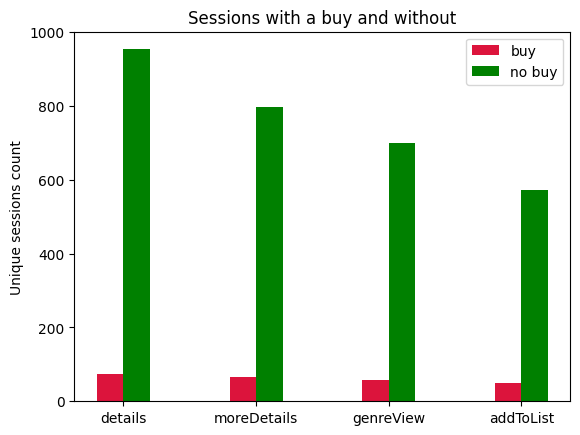

In [14]:
query_with_buy = '''
    SELECT count(*)
    FROM
    (
        SELECT DISTINCT session_id
        FROM evidence_log
        WHERE session_id IN (SELECT session_id FROM evidence_log WHERE event = 'buy') AND event = %s
    ) AS q;
'''

query_without_buy = '''
    SELECT count(*)
    FROM
    (
        SELECT DISTINCT session_id
        FROM evidence_log
        WHERE session_id in (SELECT session_id FROM evidence_log WHERE event != 'buy') AND event = %s
    ) AS q;
'''

events = ["details", "moreDetails", "genreView", "addToList"]
sessions_with_buy = list()
sessions_without_buy = list()
for event in events:
    sessions_with_buy.append(execute_query(query_with_buy, (event,))[0][0])
    sessions_without_buy.append(execute_query(query_without_buy, (event,))[0][0])

n = len(sessions_with_buy)
r = np.arange(n)
width = 0.2
plt.bar(r, sessions_with_buy, color="crimson", width=width, label="buy")
plt.bar(r + width, sessions_without_buy, color="g", width=width, label="no buy")
plt.xticks(r + width / 2, events)
plt.title("Sessions with a buy and without")
plt.ylabel("Unique sessions count")
plt.legend()
plt.show()


In [9]:
print("Top 10 content")
query = '''
    SELECT movies.title, count(*) as sold
    FROM evidence_log log
    JOIN movies ON CAST(log.content_id AS INTEGER) = CAST(movies.movie_id AS INTEGER)
    WHERE event LIKE 'buy'
    GROUP BY content_id, movies.title
    ORDER BY sold DESC
    LIMIT 10
'''
films = execute_query(query)
df = pd.DataFrame(films)
df

Top 10 content


,0,1
0,The Finest Hours,4
1,Jack Reacher: Never Go Back,4
2,Independence Day: Resurgence,3
3,Busanhaeng,3
4,Angry Birds,3
5,Assassin's Creed,2
6,Guardians of the Galaxy Vol. 2,2
7,The Huntsman: Winter's War,2
8,Logan,2
9,Money Monster,2


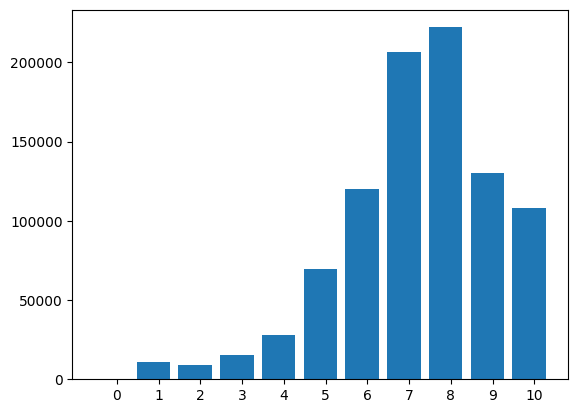

In [10]:
query = '''
    select count(*)
    from
        (
            select rating
            from ratings
            where rating = %s
        ) as q;
'''

distr = list()
for i in range(0, 11):
    distr.append(execute_query(query, (i,))[0][0])

r = np.arange(len(distr))
plt.bar(r, distr)
plt.xticks(r + width / 2, r)
plt.show()